#How to reach a position with the maximum speed
###Differences between goal_position / goto_position in minjerk / goto_position in dummy

In [2]:
from poppy.creatures import Poppy4dofArmMini

With the goto_position method, you can set an angle and a time. But you can not be absolutely sure that the position will be effectively reach. Because the priority is on the time. 

More precisely, if you are in minjerk mode for the goto_behavior the movement is a succession of goal position, so you can be confident about the position reach, but it is not certain. For example, if you overspeed the motor.

In [3]:
mini_dof = Poppy4dofArmMini()

In [4]:
for m in mini_dof.motors:
    m.compliant = False
    m.goto_position(0,1)

We need to adjust the PID of the motors, because if not you can have more than 3 degrees to difference between the present_position and the goal_position.
To know more, have a look on the activities : How to adjust the PID parameters for the motors.

In [77]:
for m in mini_dof.motors:
    m.pid=(4,1,0.1)

####Minjerk behavior :

Check, the goto_behavior :

In [99]:
mini_dof.m3.goto_behavior= 'minjerk'

In [4]:
mini_dof.m3.goto_behavior

'minjerk'

Make a primitive to record data from motors :

In [15]:
from pypot.primitive import Primitive
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
class Graph_primitive(Primitive):
    def __init__(self,robot,motors_name):
        self.robot = robot
        Primitive.__init__(self, robot)
        self.fake_motors={}
        for name in motors_name:
            self.fake_motors[name] = getattr(self.robot, name)  
        self.position={}
        self.load={}
        self.speed={}
        
    def setup(self):
        for m in self.fake_motors.keys():
            self.position[m] = []
            self.speed[m] = []
            self.load[m] = []
        self.python_time=[]
        self.pypot_time=[]
    
    def run(self):
        t0 = time.time()
        while not self.should_stop():
            for m in self.fake_motors.keys():
                self.position[m].append(self.fake_motors[m].present_position)
                self.load[m].append(self.fake_motors[m].present_load)
                self.speed[m].append(self.fake_motors[m].present_speed)
            self.python_time.append(time.time()-t0)
            self.pypot_time.append(self.elapsed_time)
            time.sleep(0.02)
            
            

In [17]:
graph = Graph_primitive(mini_dof,['m3',])

Do a simple movement :

In [58]:
graph.start()
mini_dof.m3.goto_position(90,1,wait=True)
mini_dof.m3.goto_position(0,1)
graph.stop()

Display the graph :

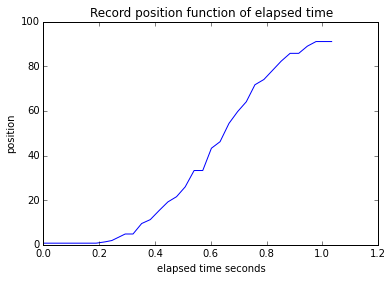

In [59]:
figure(1)
plot(graph.pypot_time,graph.position['m3'])
xlabel('elapsed time seconds')
ylabel('position')
title ('Record position function of elapsed time')

But with :

In [64]:
graph.start()
mini_dof.m3.goto_position(90,0.1,wait=True)
mini_dof.m3.goto_position(0,1,wait=True)
graph.stop()

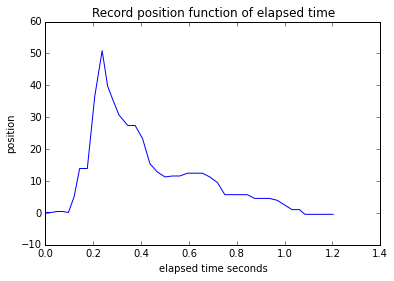

In [65]:
figure(1)
plot(graph.pypot_time,graph.position['m3'])
xlabel('elapsed time seconds')
ylabel('position')
title ('Record position function of elapsed time')

The position is definitely not reach.

####Dummy behavior

This is different in goto_behavior dummy. With this mode, there is not a succession of goal_position and time but only one command : A goal_position and a moving_speed. We can remark here that using the dummy mode certainly reduce the communication on the bus to the motors (could be a good thing).
    

Change the behavior

In [13]:
mini_dof.m3.goto_behavior = 'dummy'

Do a simple movement :

In [18]:
graph.start()
mini_dof.m3.goto_position(90,1,wait=True)
mini_dof.m3.goto_position(0,1)
graph.stop()

Display the graph :

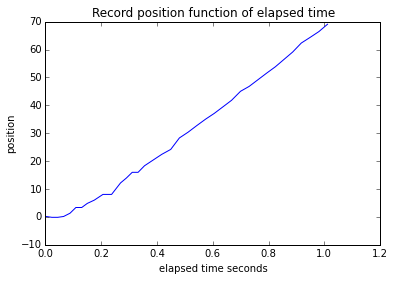

In [19]:
figure(1)
plot(graph.pypot_time,graph.position['m3'])
xlabel('elapsed time seconds')
ylabel('position')
title ('Record position function of elapsed time')

You can see that the 90 degree is not reach in one second. So the movement

And with :

In [69]:
graph.start()
for i in range(3):
    mini_dof.m3.goto_position(90,0.5,wait=True)
    mini_dof.m3.goto_position(-90,0.5,wait=True)
mini_dof.m3.goto_position(0,1,wait=True)
graph.stop()

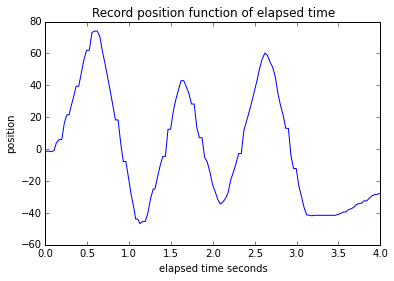

In [70]:
figure(1)
plot(graph.pypot_time,graph.position['m3'])
xlabel('elapsed time seconds')
ylabel('position')
title ('Record position function of elapsed time')

This is awful ! The position are really far from desired position. Because, pypot calcule a theorical speed wich seems to be always under the real one.

If you want to put the priority to the position and not the time, you can add an instruction to wait until the position is reach :

In [35]:
def wait_position(motor) :
    while abs(motor.present_position-motor.goal_position) > 2: # the precision in degree is 2° , you can change but usually XL-320 motors have not a precision more than 1°
        time.sleep(0.02)

In [36]:
graph.start()
for i in range(3):
    mini_dof.m3.goto_position(90,0.5)
    wait_position(mini_dof.m3)
    mini_dof.m3.goto_position(-90,0.5,wait=True)
    wait_position(mini_dof.m3)
mini_dof.m3.goto_position(0,1,wait=True)
graph.stop()

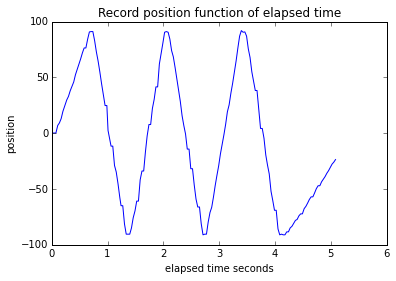

In [37]:
figure(1)
plot(graph.pypot_time,graph.position['m3'])
xlabel('elapsed time seconds')
ylabel('position')
title ('Record position function of elapsed time')

Positions are now respected (+/- : 2°) but time is not.

####goal_position and moving_speed

Set the moving_speed of the motors :

In [39]:
for m in mini_dof.motors:
    m.moving_speed = 100 # degrees per seconde

In [79]:
def wait_position(robot) :
    while abs(
        robot.m1.present_position-robot.m1.goal_position) > 5 or abs(
        robot.m2.present_position-robot.m2.goal_position) > 5 or abs(
        robot.m3.present_position-robot.m3.goal_position) >5 or abs(
        robot.m4.present_position-robot.m4.goal_position) >5 : # the precision in degree is 2° , you can change but usually XL-320 motors have not a precision more than 1°
        time.sleep(0.02)

In [85]:
for i in range(10):
    mini_dof.m1.goal_position = 90
    mini_dof.m2.goal_position = 10
    mini_dof.m3.goal_position = 80
    mini_dof.m4.goal_position = -40
    wait_position(mini_dof)
    for m in mini_dof.motors:
        m.goal_position = 0
    wait_position(mini_dof)
    mini_dof.m1.goal_position = -30
    mini_dof.m2.goal_position = 10
    mini_dof.m3.goal_position = 80
    mini_dof.m4.goal_position = -40
    wait_position(mini_dof)
    for m in mini_dof.motors:
        m.goal_position = 0
    wait_position(mini_dof)

In [65]:
for m in mini_dof.motors:
    m.moving_speed = 0 # degrees per seconde

In [86]:
mini_dof.close()